# 데이터 불러오기

In [88]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [89]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [90]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


### 데이터 확인하기

In [91]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


### 파라미터 설정

In [92]:
# parameter Initialization
batch_size = 16 #메모리 때문에 배치사이즈 줄이기
epochs = 10 #에포크 숫자 늘리기
IMG_HEIGHT = 256
IMG_WIDTH = 256

### 이미지를 시각화

In [93]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [94]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

In [95]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [96]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

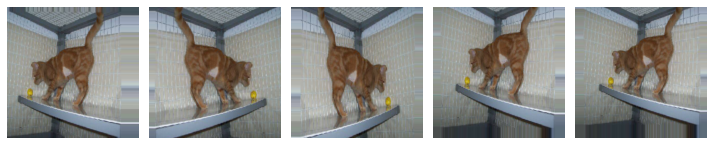

In [97]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### validation

In [98]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [99]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


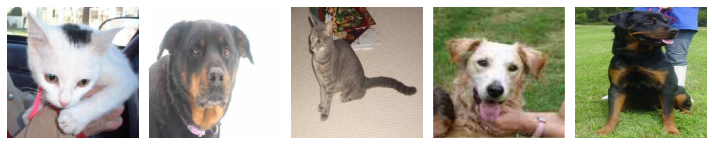

In [100]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [101]:
_[:5] # 정답 데이터

array([0., 1., 0., 1., 1.], dtype=float32)

## 모델 구현하기

In [102]:
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x) #flatten 대신에 GlobalAveragePooling
x=tf.keras.layers.Dense(512, activation='relu')(x) #Dense 적절히 만들기
x=tf.keras.layers.Dense(256, activation='relu')(x) #Dense 적절히 만들기
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_30 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 128, 128, 64)      3692

In [103]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate 조절
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [104]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=int((len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size),  # Convert to integer
    epochs=epochs,
    validation_data=val_data_gen,
    # callbacks=callbacks_list,
    validation_freq=1)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [106]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

### 변경
Epoch 10으로 늘림

batch 메모리 오류가 계속 떠서 배치는 작게 유지

flatten 대신에 global pooling사용

Dense 적절히 조절

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

이런 에러가 계속 뜸..

LMS 환경에서를 캡쳐함
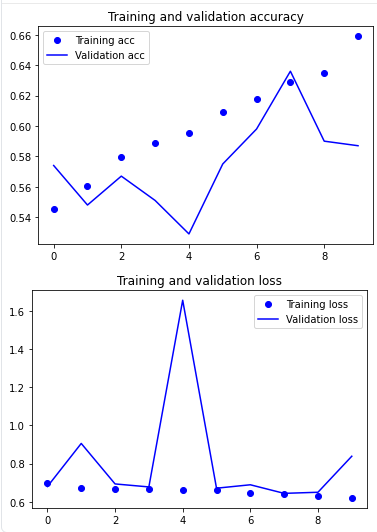

회고 : 그럼에도 accuracy를 많이 향상시키기가 어려웠다.